# Business sentiment and commodity future returns

This notebook serves as an illustration of the points discussed in the post "Business sentiment and commodity future returns" available on the Macrosynergy website. 

Business sentiment is a key driver of inventory dynamics in the global industry and, therefore, an important indicator of aggregate demand for industrial commodities. Changes in manufacturing business confidence can be aggregated by industry value added across all major economies to give a powerful direction signal of global demand for metals and energy. An empirical analysis based on information states of sentiment changes and subsequent commodity futures returns shows a clear and highly significant predictive relation. Various versions of trading signals based on short-term survey changes all produce significant long-term alpha. The predictive relation and value generation apply to all liquid commodity futures contracts.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including normalization of feature variables using z-score or building a simple linear composite indicator for commodities futures returns.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting a few simple, but powerful trading strategies targeting, in particular, vol-targeted commodity future return (`COXR_VT10`). The strategies  utilize manufacturing confidence scores based indicators derived in the previous section.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Uncomment below for new downloads
"""
%%capture
! pip install macrosynergy --upgrade"""

'\n%%capture\n! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [3]:
# General cross-sections lists
cids_ecos = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "USD",  # DM
    "BRL",
    "COP",
    "CLP",
    "MXN",
    "PEN",  # Latam
    "CZK",
    "HUF",
    "ILS",
    "PLN",
    "RON",
    "RUB",
    "TRY",
    "ZAR",  # EMEA
    "CNY",
    "HKD",
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "SGD",
    "TWD",  # EM Asia
]

# Commodity cids split in three groups: base metals, precious metals and fuels and energy
cids_bams = ["ALM", "CPR", "LED", "NIC", "TIN", "ZNC"]  # base metals
cids_prms = ["PAL", "PLT"]  # precios metals
cids_fuen = ["BRT", "WTI", "NGS", "GSO", "HOL"]  # fuels and energy

cids_coms = cids_bams + cids_prms + cids_fuen

In [4]:
# Category tickers
main = [
    ## CONFIDENCE
    "MBCSCORE_SA",
    "MBCSCORE_SA_3MMA",
    "MBCSCORE_SA_D1M1ML1",
    "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D1Q1QL1",
    "MBCSCORE_SA_D6M6ML6",
    "MBCSCORE_SA_D2Q2QL2",
    ## ORDERS
    "MBOSCORE_SA",
    "MBOSCORE_SA_3MMA",
    "MBOSCORE_SA_D1M1ML1",
    "MBOSCORE_SA_D3M3ML3",
    "MBOSCORE_SA_D1Q1QL1",
    "MBOSCORE_SA_D6M6ML6",
    "MBOSCORE_SA_D2Q2QL2",
    ## INDUSTRIAL ADDED VALUE
    "IVAWGT_SA_1YMA",
]
rets = ["COXR_VT10"]

xcats = main + rets

# Extra tickers

xtix = ["USD_EQXR_NSA", "USD_GB10YXR_NSA"]

# Resultant tickers

tix1 = [cid + "_" + xc for cid in cids_ecos for xc in main]
tix2 = [cid + "_" + xc for cid in cids_coms for xc in rets]

tickers = tix1 + tix2 + xtix

print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 495


The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/), or [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected). For tickers used in this notebook see [Manufacturing confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Manufacturing%20confidence%20scores.php), [Global production shares](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Shares%20in%20global%20production.php?highlight=ivawgt), and [Commodity future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php).

In [5]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1995-01-01"
end_date = "2023-07-01"

# Retrieve credentials
client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        end_date=end_date,
        suppress_warning=True,
        metrics=["all"],
        report_time_taken=True,
        show_progress=True,
    )

Timestamp UTC:  2024-03-27 11:52:24
Connection successful!


Requesting data:  34%|███▍      | 34/99 [00:06<00:13,  4.97it/s]

Requesting data: 100%|██████████| 99/99 [00:21<00:00,  4.68it/s]


Time taken to download data: 	44.49 seconds.
Some expressions are missing from the downloaded data. Check logger output for complete list.
680 out of 1980 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.


In [6]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1986471 entries, 9493 to 1986470
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   eop_lag    float64       
 4   grading    float64       
 5   mop_lag    float64       
 6   value      float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 121.2+ MB


## Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

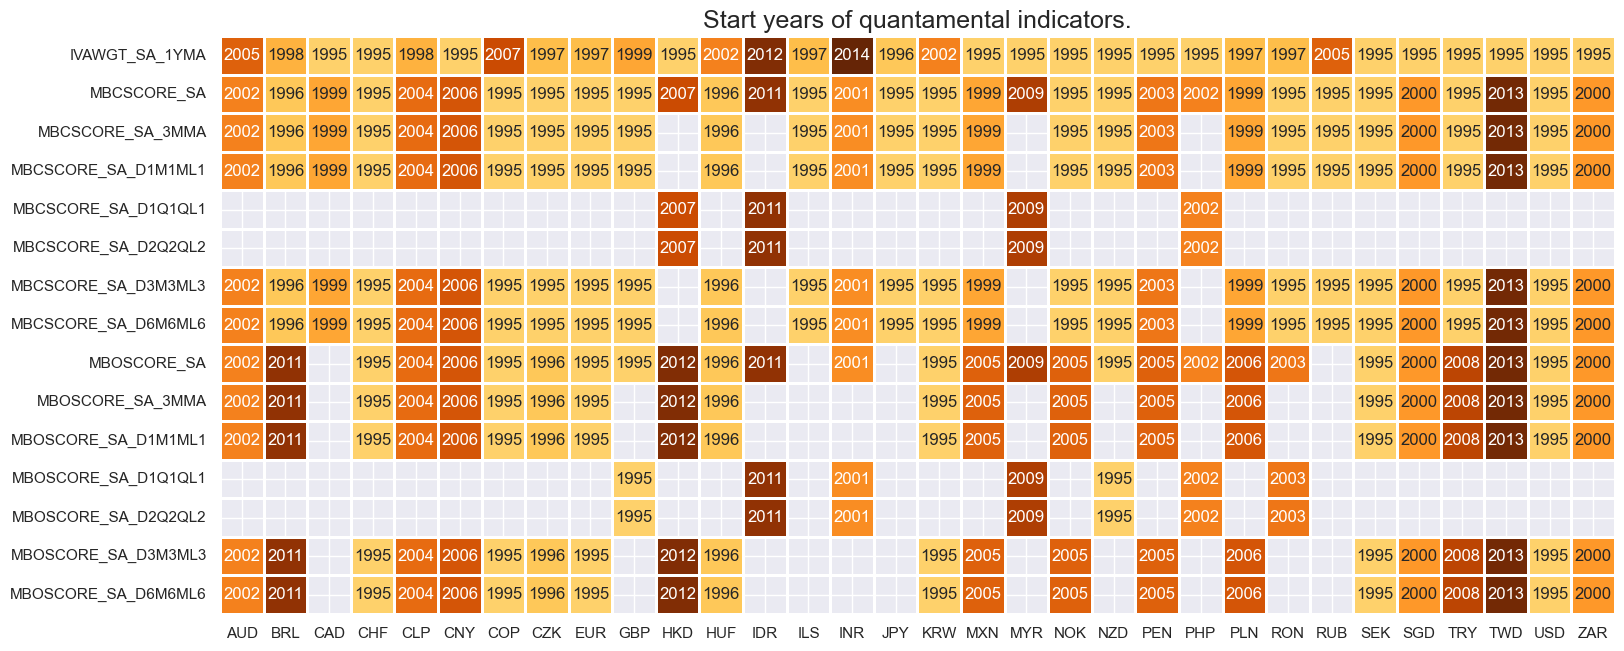

In [7]:
msm.check_availability(df, xcats=main, cids=cids_ecos, missing_recent=False)

Due to the mixed frequency nature of manufacturing surveys (some countries monthly and some quarterly), we align the categories to the monthly version to be consistent.

In [8]:
dict_repl = {
    "MBCSCORE_SA_D1Q1QL1": "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D2Q2QL2": "MBCSCORE_SA_D6M6ML6",
    "MBOSCORE_SA_D1Q1QL1": "MBOSCORE_SA_D3M3ML3",
    "MBOSCORE_SA_D2Q2QL2": "MBOSCORE_SA_D6M6ML6",
}
for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

scores = [
    "MBCSCORE_SA_D1M1ML1",
    "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D6M6ML6",
    "MBOSCORE_SA_D1M1ML1",
    "MBOSCORE_SA_D3M3ML3",
    "MBOSCORE_SA_D6M6ML6",
]

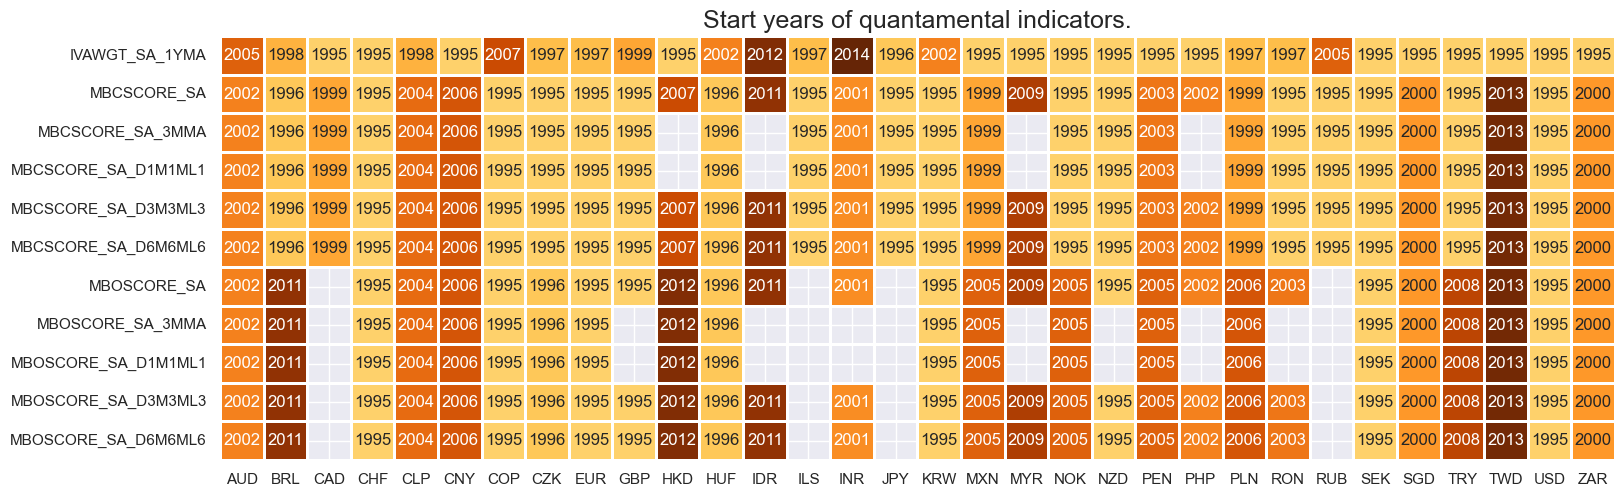

In [9]:
msm.check_availability(dfx, xcats=main, cids=cids_ecos, missing_recent=False)

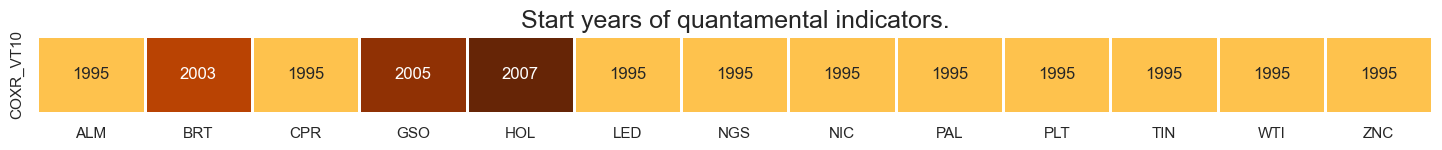

In [10]:
msm.check_availability(df, xcats=rets, cids=cids_coms, missing_recent=False)

# Transformations and checks

### Local normalization of confidence dynamics

Normalizing values across different categories is a common practice in macroeconomics. This is particularly important when summing or averaging categories with different units and time series properties. Using `macrosynergy's` custom function [`make_zn_scores()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#normalize-panels-with-make-zn-scores) we normalize the selected scores around neutral value (zero), using only past information. Re-estimation is done on monthly basis, and we use a minimum of 5 years data. We protect against outliers using 4 standard deviations as threshold. The normalized indicators receive postfix `_ZN`

In [11]:
xcatx = scores
cidx = cids_ecos

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 5,  # minimum requirement is 5 years of daily data
        neutral="zero",
        pan_weight=0,
        thresh=4,  # protects against outliers
        postfix="_ZN",
        est_freq="m",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

scorez = [s + "_ZN" for s in scores]

The resulting normalized changes on manufacturing business confidence scores are displayed for comparison with the help of customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

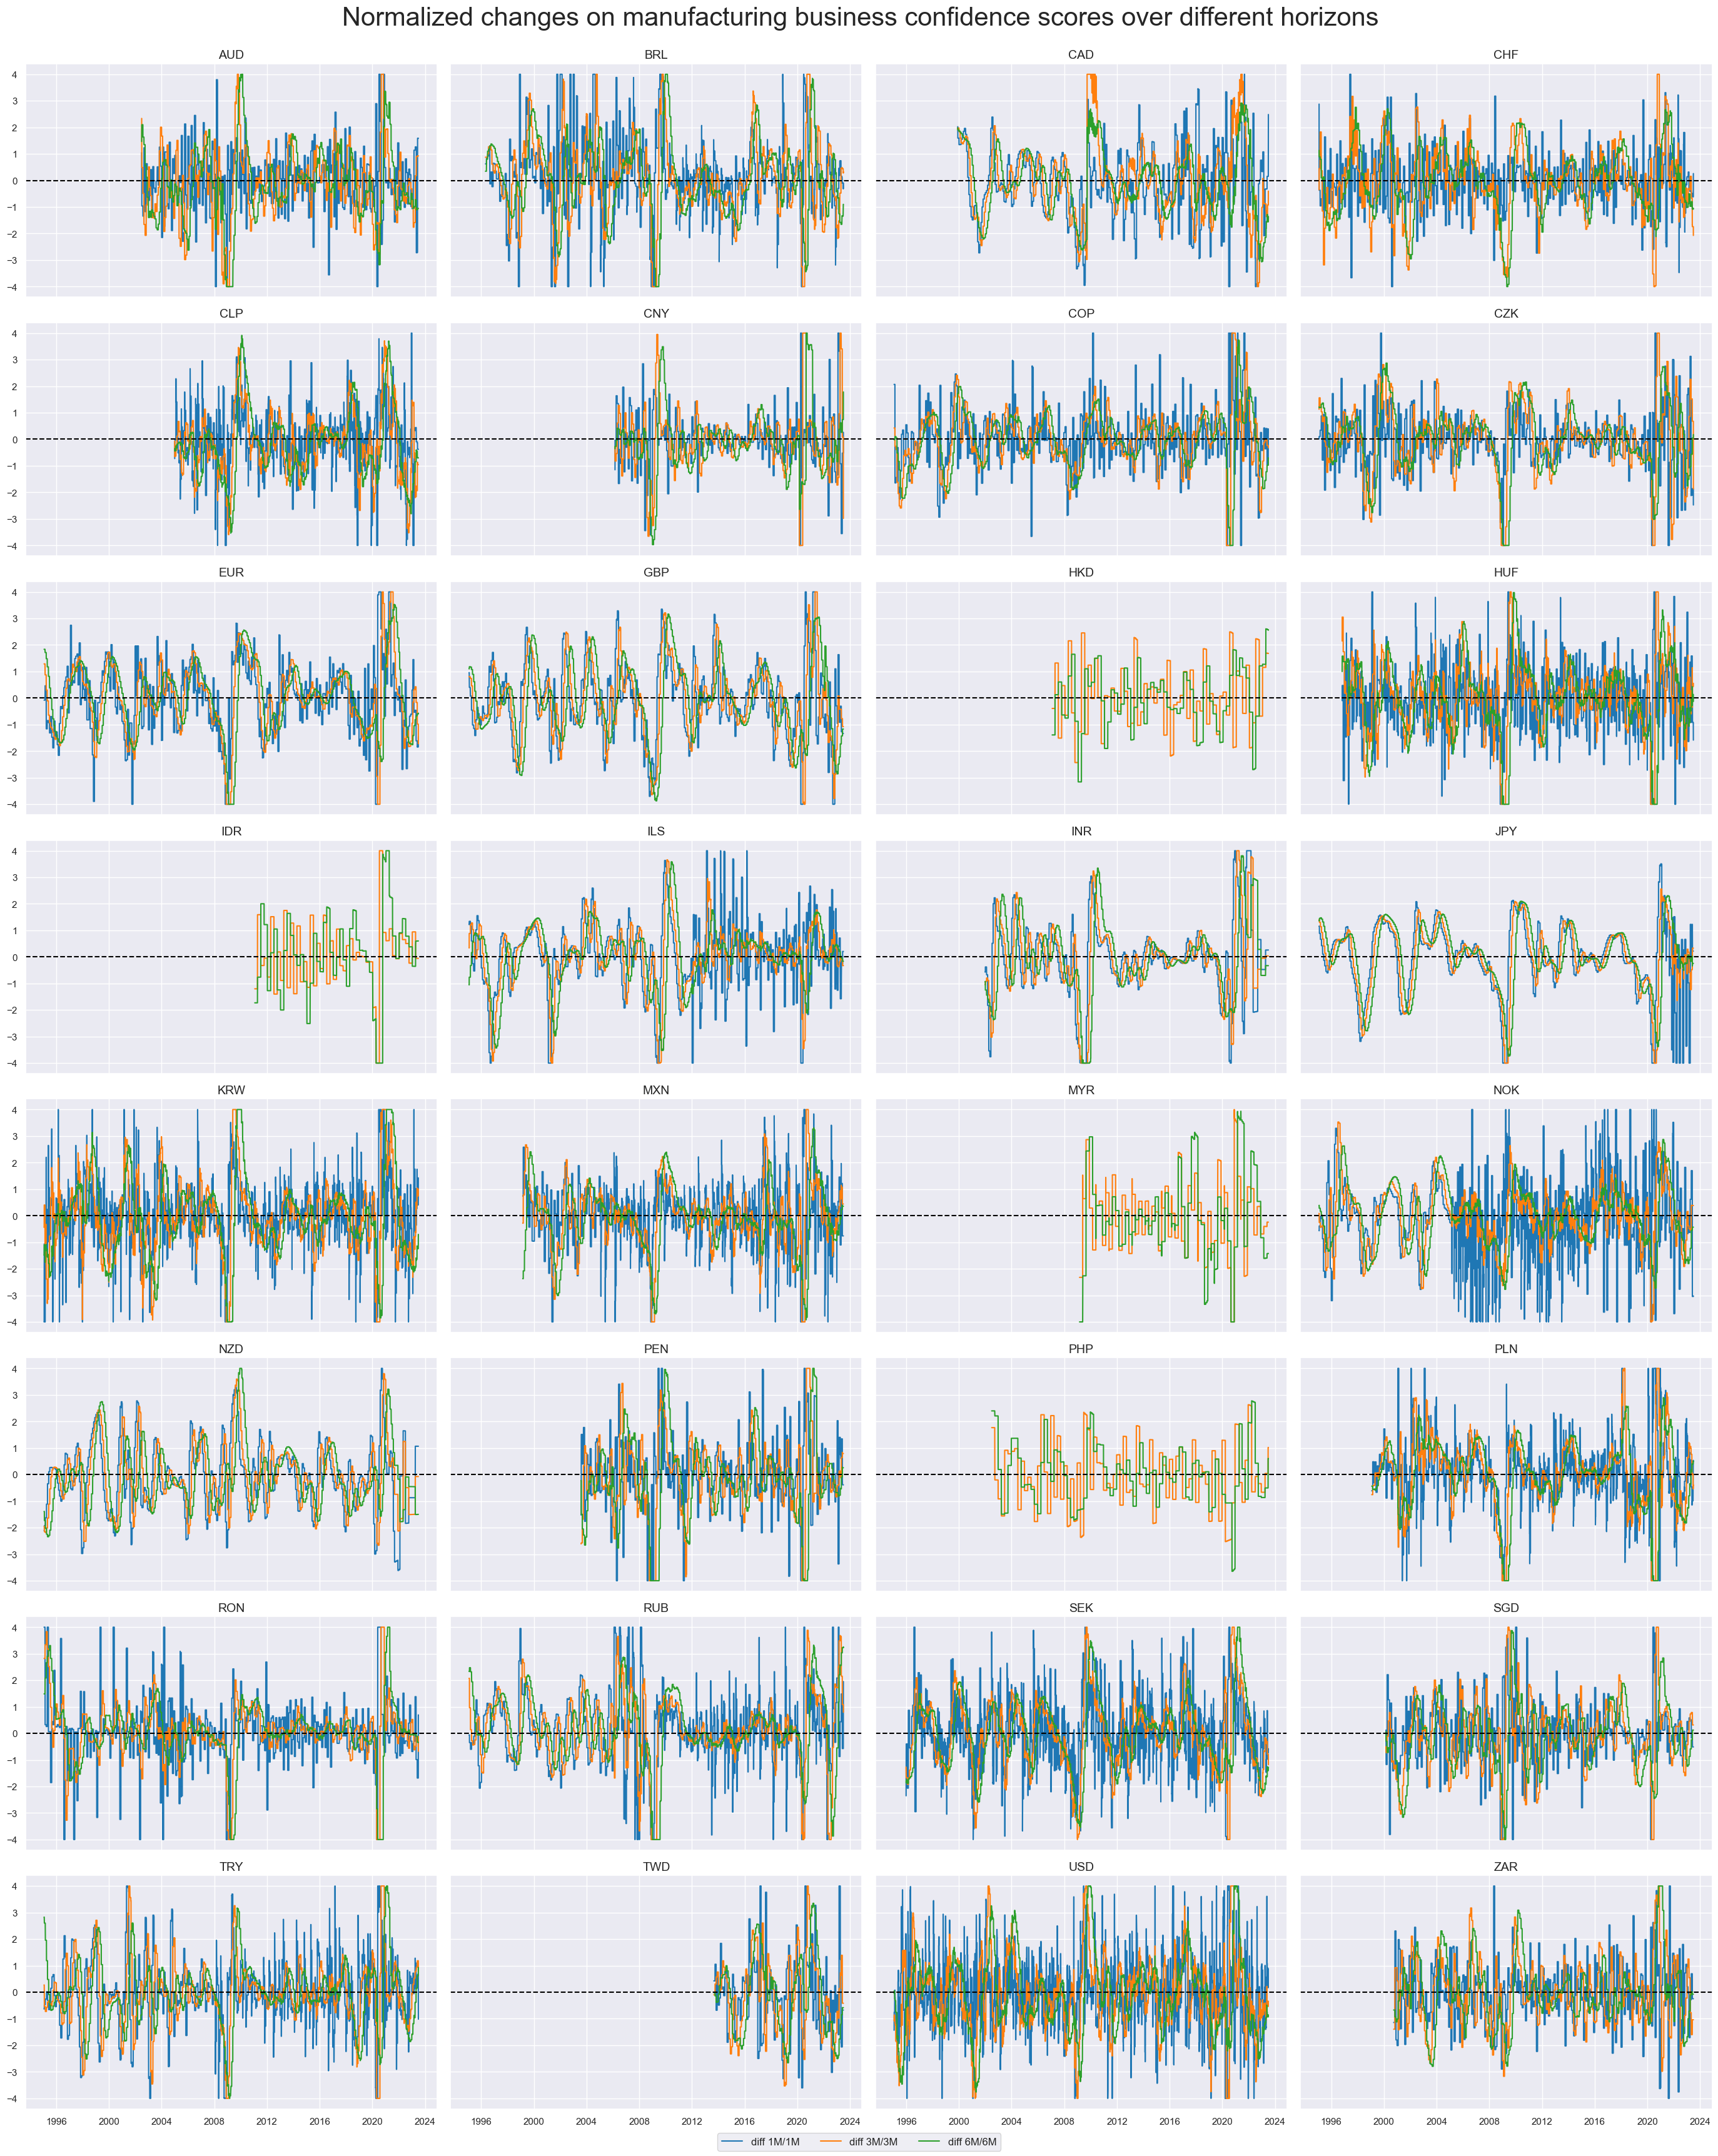

In [12]:
xcatx = [s for s in scorez if "MBC" in s]
cidx = cids_ecos

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    start="1995-01-01",
    title="Normalized changes on manufacturing business confidence scores over different horizons",
    title_fontsize=30,
    same_y=True,
    xcat_labels=["diff 1M/1M", "diff 3M/3M", "diff 6M/6M"],
)

### Global composite of manufacturing confidence and order dynamics

We have prepared a visualization to illustrate the shifts in production shares `IVAWGT_SA_1YMA` over the past 23 years. Notably, the most significant transformations in this visual representation include a substantial surge in the share attributed to CNY (Chinese Yuan), contrasted by noticeable declines in the shares of the primary developed economies, namely USD (US Dollar), EUR (Euro), GBP (British Pound), and JPY (Japanese Yen). 

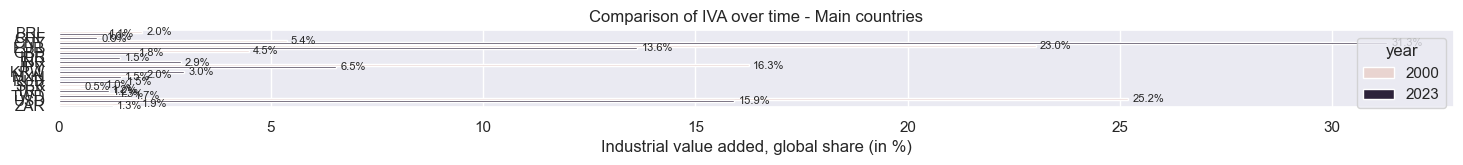

(None, None)

In [13]:
# Extract values and labels for the latest filtered data
prod2023 = (dfx["xcat"] == "IVAWGT_SA_1YMA") & (dfx["real_date"] == "2023-06-30")
prod_share_2023 = dfx.loc[prod2023]

# Extract values and labels for the early filtered data
prod2000 = (dfx["xcat"] == "IVAWGT_SA_1YMA") & (dfx["real_date"] == "2000-06-30")
prod_share_2000 = dfx.loc[prod2000]

# combine
iv_data_comparison = pd.concat(
    [prod_share_2023.assign(year=2023), prod_share_2000.assign(year=2000)],
    axis=0,
    ignore_index=True,
)
iv_data_comparison["value"] = iv_data_comparison["value"] * 100

# selecting more meaningful countries
main_cids = list(
    set(
        iv_data_comparison.loc[
            (iv_data_comparison["year"] == 2000) & (iv_data_comparison["value"] > 1),
            "cid",
        ].tolist()
        + iv_data_comparison.loc[
            (iv_data_comparison["year"] == 2023) & (iv_data_comparison["value"] > 1),
            "cid",
        ].tolist()
    )
)

ax = sns.barplot(
    data=iv_data_comparison.loc[iv_data_comparison["cid"].isin(main_cids)],
    x="value",
    y="cid",
    hue="year",
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=8, padding=3)

ax.set_xlabel("Industrial value added, global share (in %)")
ax.set_ylabel("")
ax.set_title("Comparison of IVA over time - Main countries")

# Adjust layout
plt.tight_layout(), plt.show()

For all the cross-sections, utilizing the previously computed z-scores derived from manufacturing confidence, we construct a comprehensive global composite indicator. This composite indicator is weighted by the corresponding shares in the overall world industry value added, taking into account a 1-year moving average (`IVAWGT_SA_1YMA`). The created global composite indicator receives postfix `_GLB`

In [14]:
cidx = cids_ecos
xcatx = scorez

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    if "D1M1ML1" in xc:
        cidx = list(set(cidx).intersection(set(dfx[dfx["xcat"] == xc]["cid"].unique())))
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xc,
        cids=cidx,
        weights="IVAWGT_SA_1YMA",
        new_cid="GLB",
        complete_cids=False,
        complete_xcats=False,
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

The resulting normalized changes in manufacturing confidence scores for the three types of lookback (difference over 1 month / difference of last 3 months over previous 3 months / difference of last 6 months over previous 6 months) are displayed for comparison with the help of customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

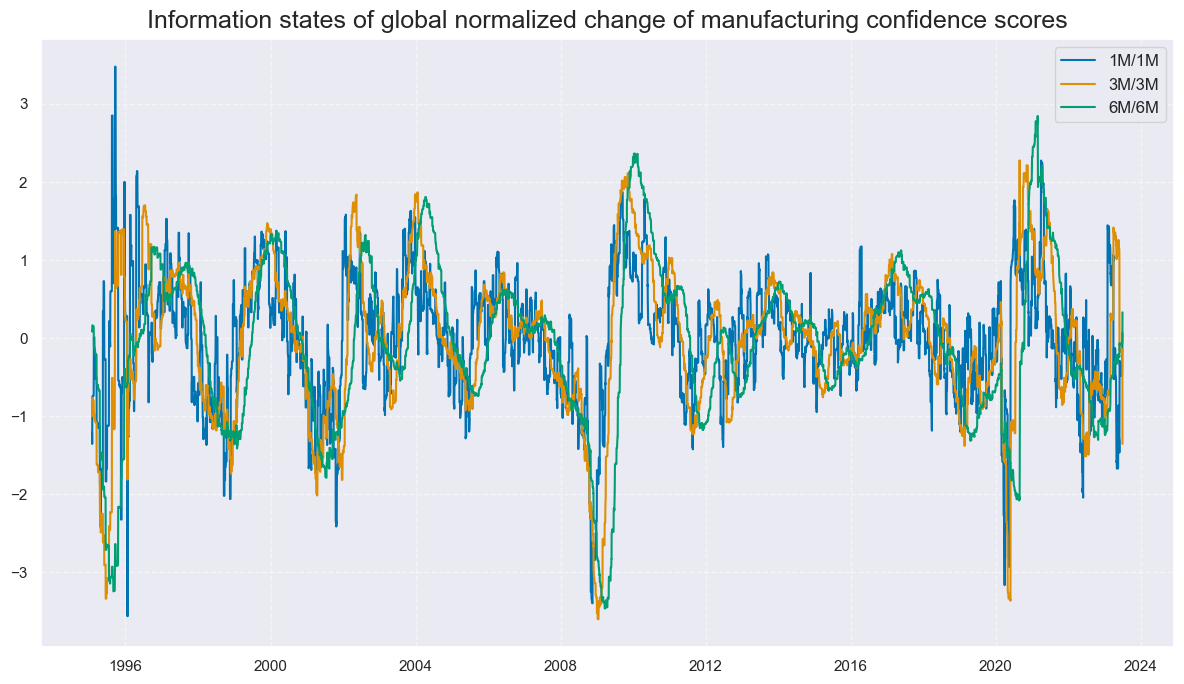

In [15]:
xcatx = [s for s in scorez if "MBC" in s]
cidx = ["GLB"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    start="1995-01-01",
    title="Information states of global normalized change of manufacturing confidence scores",
    same_y=True,
    xcat_labels=["1M/1M", "3M/3M", "6M/6M"],
)

 Here we adopt an approach of uniform weighting for the normalized composite scores, derived above from 1-month/1-month, 3-month/3-month, and 6-month/6-month periods. The resulting indicator is composite indicator that encapsulates the global information state of the manufacturing confidence scores. This novel indicator is denoted as `MBCSCORE_DZC`. Subsequently, we proceed to visually represent this indicator through plotting.

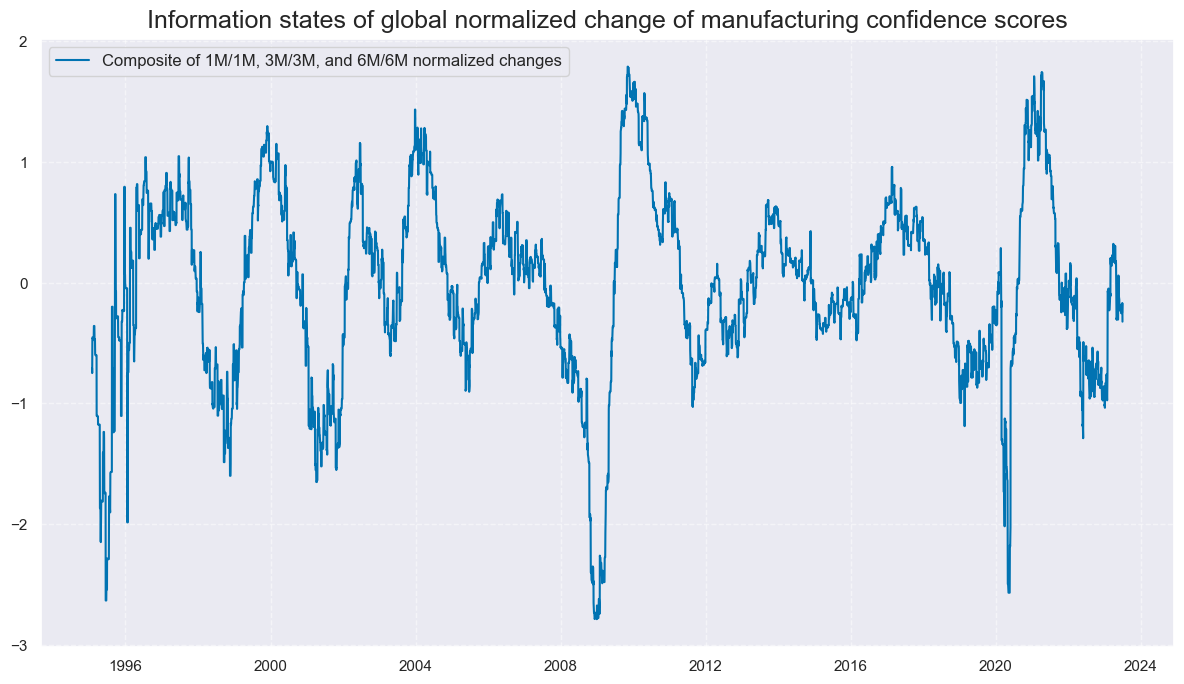

In [16]:
xcatx = [s for s in scorez if "MBC" in s]
cidx = cids_ecos + ["GLB"]

dfa = msp.linear_composite(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    complete_xcats=False,
    new_xcat="MBCSCORE_DZC",
)

dfx = msm.update_df(dfx, dfa)

xcatx = ["MBCSCORE_DZC"]
cidx = ["GLB"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    start="1995-01-01",
    title="Information states of global normalized change of manufacturing confidence scores",
    same_y=True,
    xcat_labels=["Composite of 1M/1M, 3M/3M, and 6M/6M normalized changes"],
)

## Targets

### Vol-targeted commodity returns

The present analysis focuses on dollar-denominated futures returns of the most liquid industrial commodities outside China. These returns are based on positions in the front contract of the most liquid available future of each type of commodity. The post specifies the following underlying materials as industrial commodities:

- Base metals: London Metal Exchange aluminum (ALM), Comex copper (CPR), London Metal Exchange Lead (LED), London Metal Exchange Nickel (NIC), London Metal Exchange Tin (TIN), and London Metal Exchange Zinc (ZNC).
- Precious metals: NYMEX palladium (PAL) and NYMEX platinum (PLT)
- Fuels: ICE Brent crude (BRT), NYMEX WTI light crude (WTI), NYMEX natural gas, Henry Hub (NGS), NYMEX RBOB Gasoline (GSO), and NYMEX Heating oil, New York Harbor ULSD (HOL)

Please see full documentation of Vol-targeted commodity future returns [here](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Commodity%20future%20returns.php#vol-targeted-commodity-future-return)


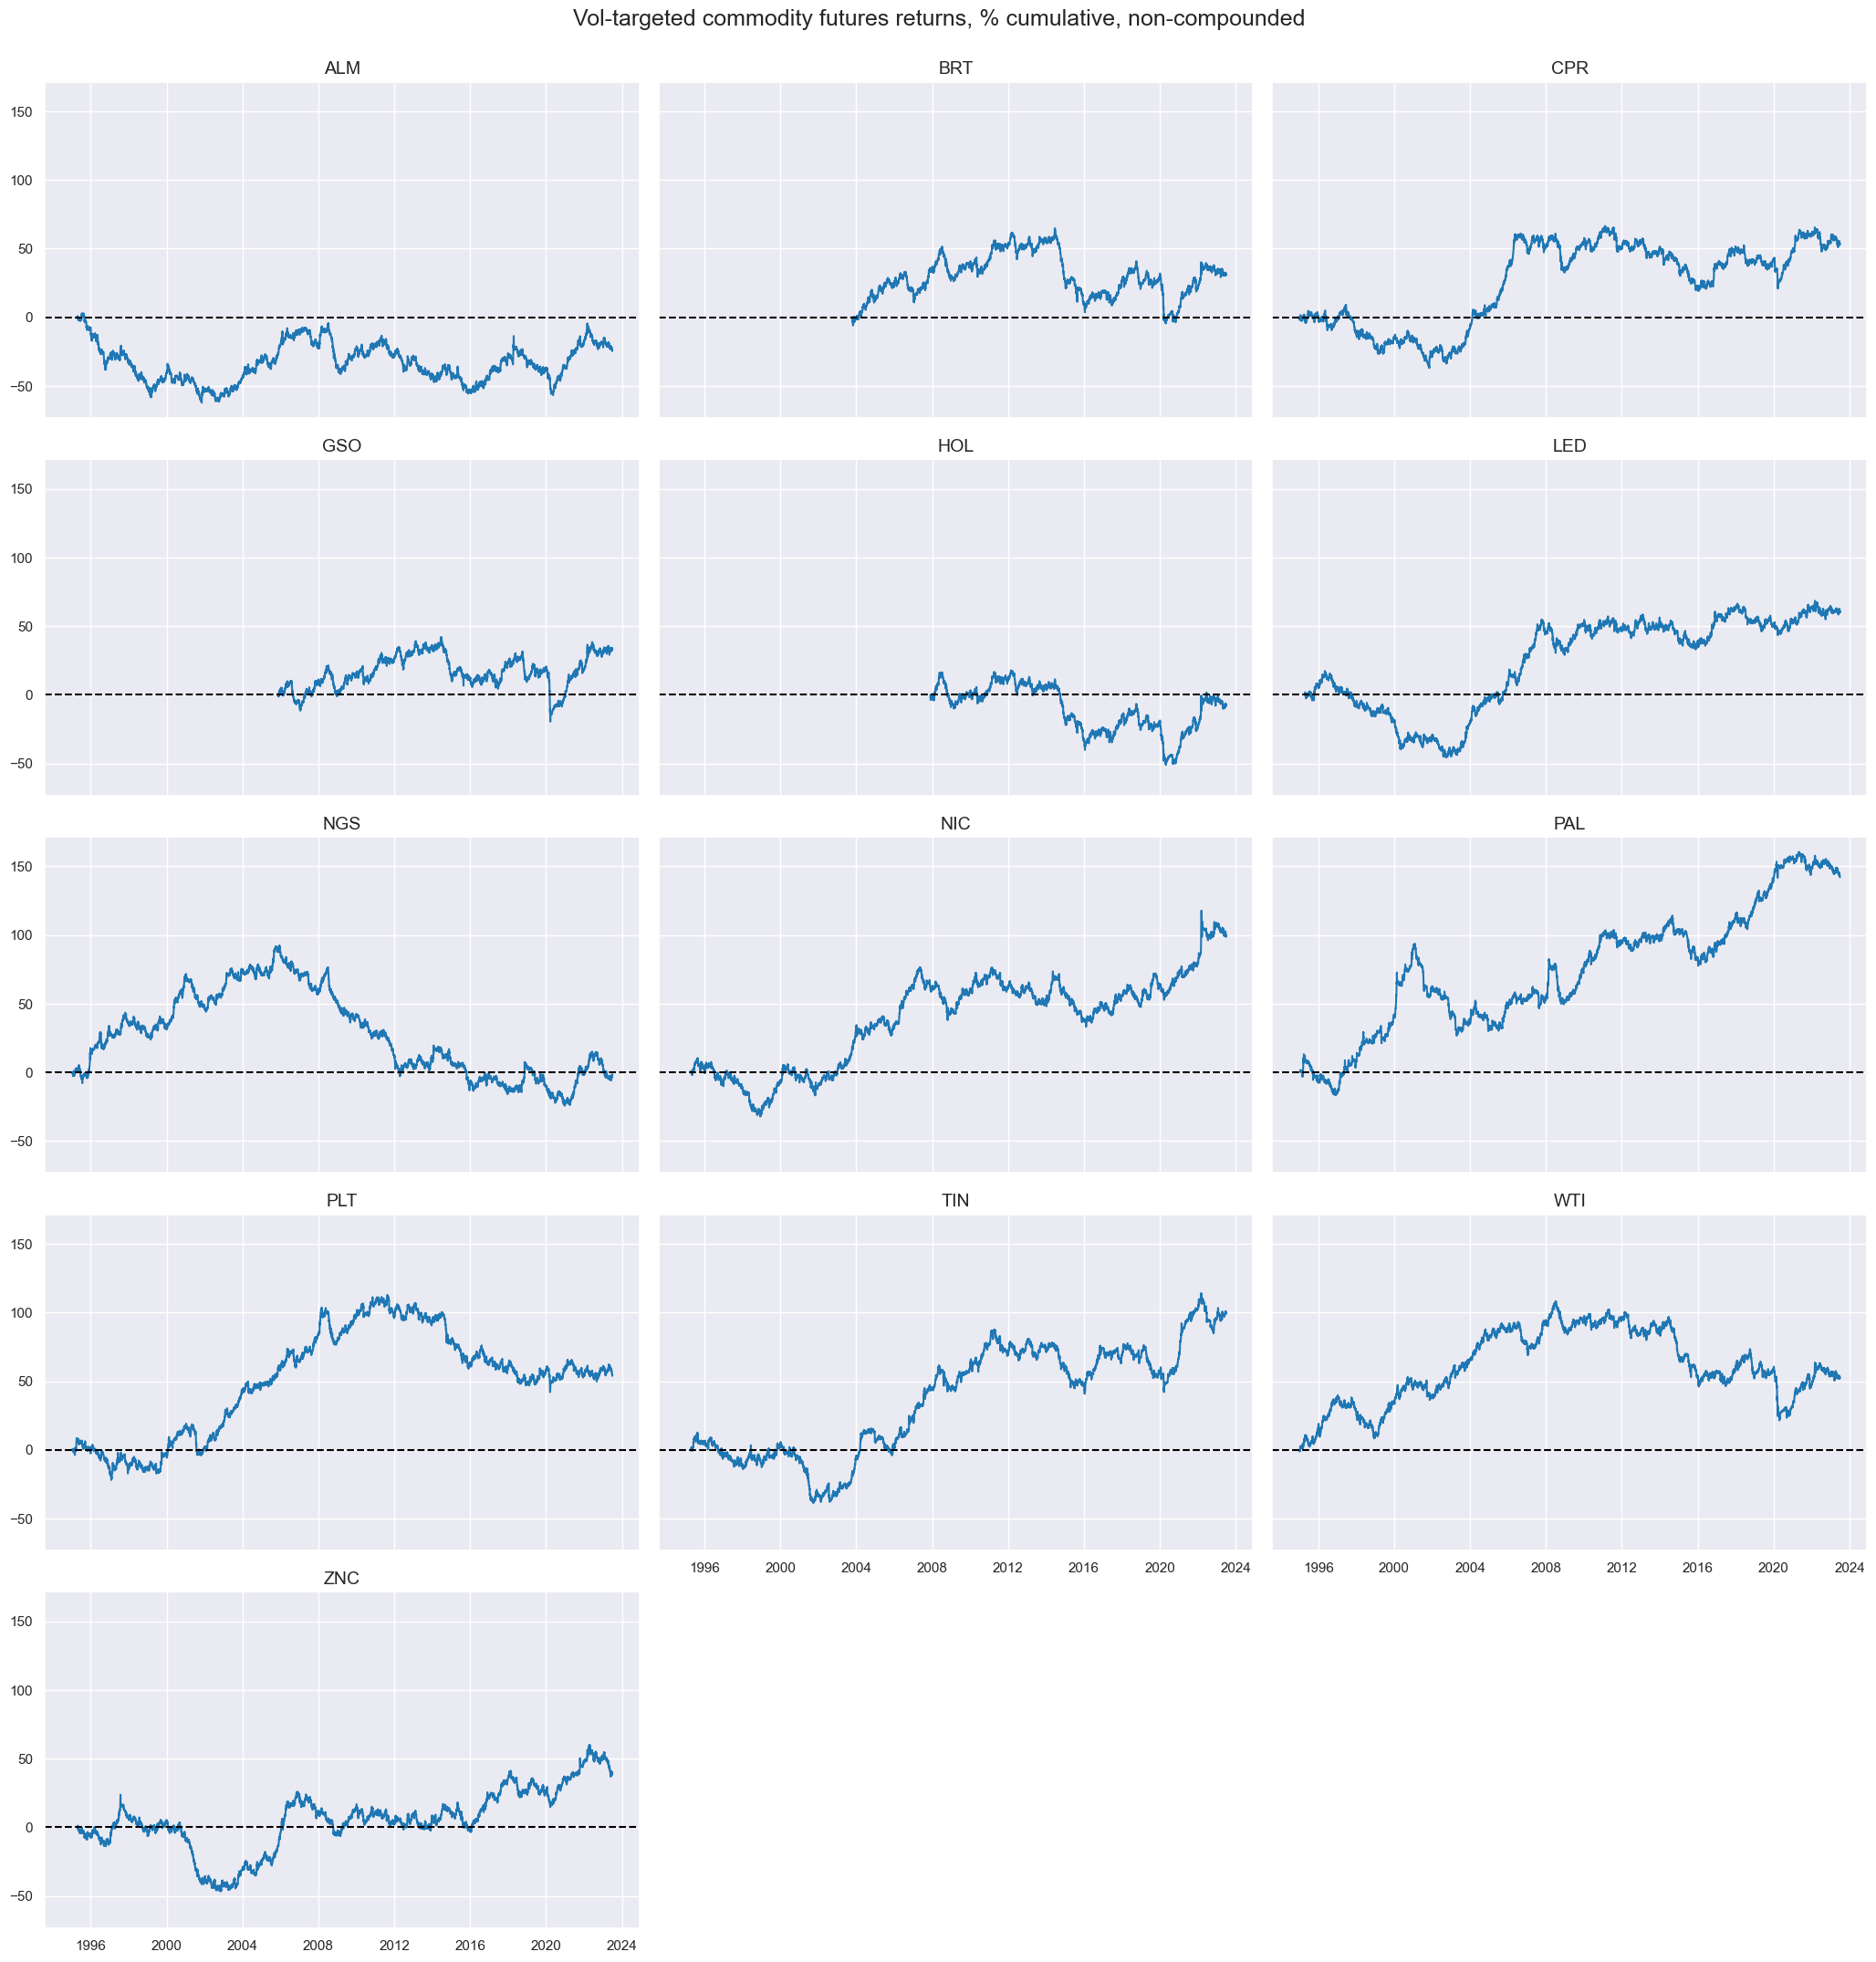

In [17]:
xcatx = ["COXR_VT10"]
cidx = cids_coms

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    cumsum=True,
    start="1995-01-01",
    title="Vol-targeted commodity futures returns, % cumulative, non-compounded",
    same_y=True,
)

Here we create an industrial commodities futures basket for aluminum (ALM),  copper (CPR), Lead (LED), Nickel (NIC), Tin (TIN), Zinc (ZNC), palladium (PAL), platinum (PLT), Brent crude (BRT), light crude (WTI), natural gas (NGS), gasoline (GSO), Heating oil (HOL). The new indicator keeps the name `COXR_VT10`, but received new cross-section name `COMS`. This broad basket will be later used to test the predictive power of business confidence changes on this basket to mitigate the influence of supply and sectoral demand shocks.


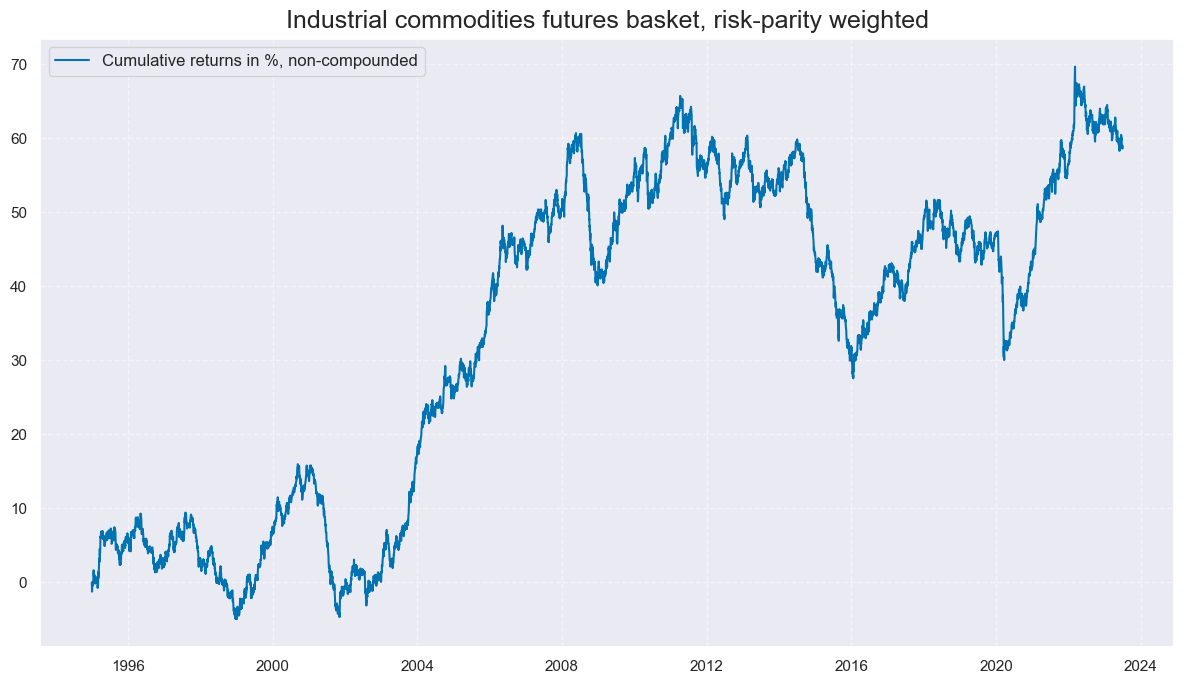

In [18]:
dict_bsks = {
    "COMS": cids_coms,
}

dfa = pd.DataFrame(columns=list(dfx.columns))
for key, value in dict_bsks.items():
    dfaa = msp.linear_composite(
        df=dfx,
        xcats="COXR_VT10",
        cids=value,
        new_cid=key,
        complete_cids=False,
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)
cids_groups = list(dict_bsks.keys())

xcatx = ["COXR_VT10"]
cidx = ["COMS"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=True,
    start="1995-01-01",
    title="Industrial commodities futures basket, risk-parity weighted",
    same_y=True,
    xcat_labels=["Cumulative returns in %, non-compounded"],
)

# Value checks

## Global basket

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for commodity future returns using the previously derived normalized confidence scores. The PnLs are calculated based on simple trading strategies that utilize the scores as signals (no regression is involved). The strategies involve going long (buying) or short (selling) on commodity positions based purely on the direction of the score signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the changes in global confidence score and consequent commodity returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of the confidence score based strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these simple confidence score strategies with the long-only performance of the respective asset classes. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

In [19]:
bname = "COMS"
dict_repl = {"GLB": bname}  # equalize identifier names for country and commodity basket
dfxx = dfx.copy()
dfxx["cid"] = dfxx["cid"].replace(dict_repl)

sigs = [s for s in scorez if "MBC" in s] + ["MBCSCORE_DZC"]
# Note: order scores excluded for post because they do not much change results
ms = "MBCSCORE_DZC"
oths = list(set(sigs) - set([ms]))  # other signals
targ = "COXR_VT10"
cidx = [bname]

dict_cogb = {
    "df": dfxx,
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "black": None,
    "srr": None,
    "pnls": None,
}

Using function `CategoryRelations()` from `macrosynergy` package we visualize the relationship between the main signal and the target. The function allows aggregation (last value for signal and sum for target), we choose monthly reestimation frequency and lag of 1 month (i.e. we estimate the relationship between the signal and subsequent target and thus test the signal's predictive power). As the signal we use composite normalized change in global confidence score `MBCSCORE_DZC` and the target is commodity basket return `COXR_VT10`

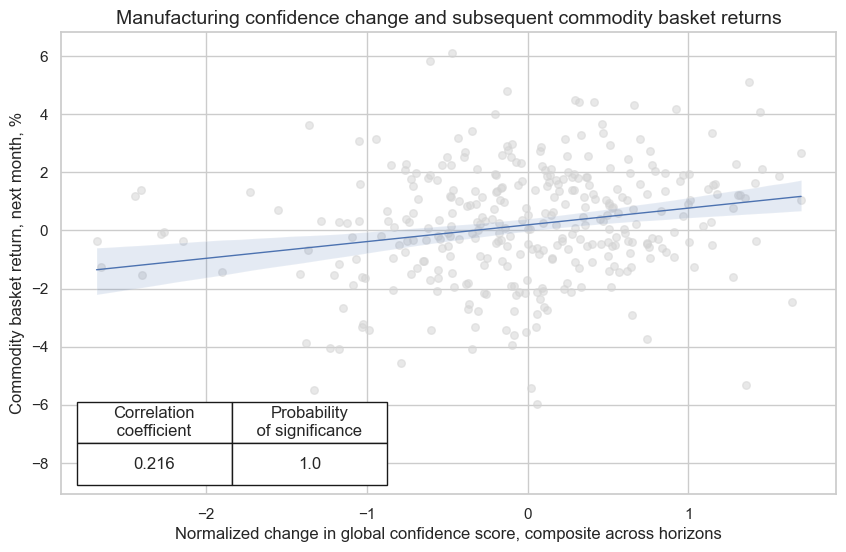

In [20]:
dix = dict_cogb

dfr = dix["df"]
sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]

crx = msp.CategoryRelations(
    dfr,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="1995-01-01",
    xcat_trims=[None, None],
)

crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Normalized change in global confidence score, composite across horizons",
    ylab="Commodity basket return, next month, %",
    title="Manufacturing confidence change and subsequent commodity basket returns",
    size=(10, 6),
)

### Accuracy and correlation check

Accuracy and balanced accuracy of correct prediction of commodity market direction are both 56.6% at the monthly frequency. Non-parametric correlation of survey changes and subsequent monthly commodity returns, based on the Kendall metric, is likewise highly significant.

accuracy  \
Return    Signal                 Frequency Aggregation             
COXR_VT10 MBCSCORE_DZC           M         last            0.566   
          MBCSCORE_SA_D1M1ML1_ZN M         last            0.587   
          MBCSCORE_SA_D3M3ML3_ZN M         last            0.566   
          MBCSCORE_SA_D6M6ML6_ZN M         last            0.545   

                                                        bal_accuracy  \
Return    Signal                 Frequency Aggregation                 
COXR_VT10 MBCSCORE_DZC           M         last                0.566   
          MBCSCORE_SA_D1M1ML1_ZN M         last                0.585   
          MBCSCORE_SA_D3M3ML3_ZN M         last                0.565   
          MBCSCORE_SA_D6M6ML6_ZN M         last                0.546   

                                                        pos_sigr  pos_retr  \
Return    Signal                 Frequency Aggregation                       
COXR_VT10 MBCSCORE_DZC           M         last            0.504     0.545   
          MBCSCORE_SA_D1M1ML1_ZN M         last            0.519     0.545   
          MBCSCORE_SA_D3M3ML3_ZN M         last            0.510     0.545   
          MBCSCORE_SA_D6M6ML6_ZN M         last            0.490     0.545   

                                                        pos_prec  neg_prec  \
Return    Signal                 Frequency Aggregation                       
COXR_VT10 MBCSCORE_DZC           M         last            0.610     0.521   
          MBCSCORE_SA_D1M1ML1_ZN M         last            0.627     0.543   
          MBCSCORE_SA_D3M3ML3_ZN M         last            0.609     0.521   
          MBCSCORE_SA_D6M6ML6_ZN M         last            0.593     0.500   

                                                        pearson  pearson_pval  \
Return    Signal                 Frequency Aggregation                          
COXR_VT10 MBCSCORE_DZC           M         last           0.216         0.000   
          MBCSCORE_SA_D1M1ML1_ZN M         last           0.241         0.000   
          MBCSCORE_SA_D3M3ML3_ZN M         last           0.179         0.001   
          MBCSCORE_SA_D6M6ML6_ZN M         last           0.142         0.009   

                                                        kendall  kendall_pval  \
Return    Signal                 Frequency Aggregation                          
COXR_VT10 MBCSCORE_DZC           M         last           0.140         0.000   
          MBCSCORE_SA_D1M1ML1_ZN M         last           0.171         0.000   
          MBCSCORE_SA_D3M3ML3_ZN M         last           0.120         0.001   
          MBCSCORE_SA_D6M6ML6_ZN M         last           0.100         0.006   

                                                          auc  
Return    Signal                 Frequency Aggregation         
COXR_VT10 MBCSCORE_DZC           M         last         0.566  
          MBCSCORE_SA_D1M1ML1_ZN M         last         0.585  
          MBCSCORE_SA_D3M3ML3_ZN M         last         0.566  
          MBCSCORE_SA_D6M6ML6_ZN M         last         0.547

accuracy  bal_accuracy  pos_sigr  pos_retr  \
M: MBCSCORE_DZC/last => COXR_VT10     0.566         0.566     0.504     0.545   
Mean years                            0.562         0.568     0.500     0.542   
Positive ratio                        0.517         0.586     0.483     0.586   
Mean cids                             0.566         0.566     0.504     0.545   
Positive ratio                        1.000         1.000     1.000     1.000   

                                   pos_prec  neg_prec  pearson  pearson_pval  \
M: MBCSCORE_DZC/last => COXR_VT10     0.610     0.521    0.216         0.000   
Mean years                            0.465     0.448    0.141         0.346   
Positive ratio                        0.448     0.276    0.759         0.552   
Mean cids                             0.610     0.521    0.216         0.000   
Positive ratio                        1.000     1.000    1.000         1.000   

                                   kendall  kendall_pval    auc  
M: MBCSCORE_DZC/last => COXR_VT10    0.140         0.000  0.566  
Mean years                           0.073         0.424  0.534  
Positive ratio                       0.690         0.345  0.345  
Mean cids                            0.140         0.000  0.566  
Positive ratio                       1.000         1.000  1.000

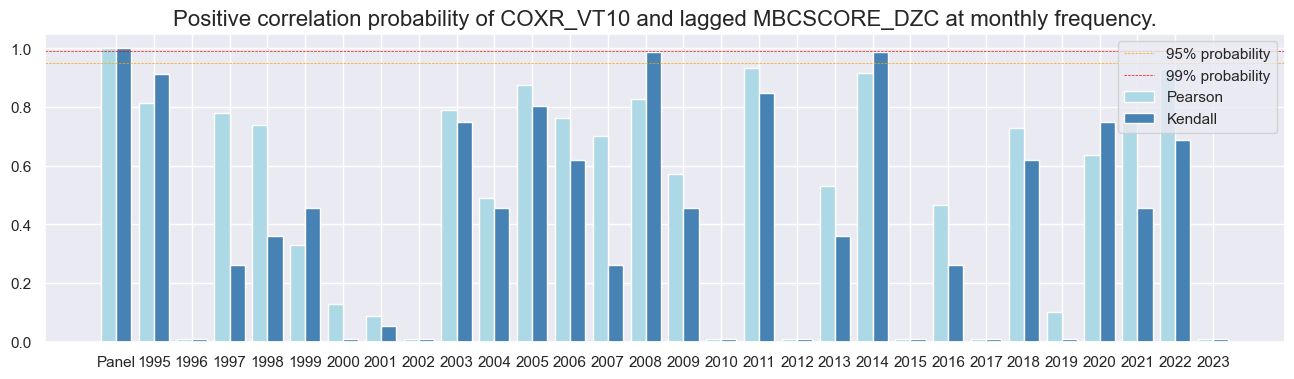

In [21]:
dix = dict_cogb

dfr = dix["df"]
sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]

srr = mss.SignalReturnRelations(
    dfr,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="1995-01-01",
)

dix["srr"] = srr

dix = dict_cogb
srrx = dix["srr"]
display(srrx.signals_table().sort_index().astype("float").round(3))

display(srrx.summary_table().astype("float").round(3))

srrx.correlation_bars(
    type="years",
    title=None,
    size=(16, 4),
)

### Naive PnL

To gauge the quality of value generation of survey-based commodity positions, we calculate stylized PnLs, i.e., dollar-based profit and loss developments over and above funding costs, according to standard rules that were applied in previous posts.

Positions are taken in the risk-parity industrial commodity futures basket following the normalized survey score changes. We consider 
- proportionate positioning, in accordance with normalized signal and a limit of 3 standard deviations, and 
- binary positioning, i.e., unit long or short positions in accordance with the sign of the survey score change.

Positions are re-calculated weekly at the end of the week and re-balanced in the following with a one-day slippage for trading time.
The long-term volatility of the PnL for positions across all currency areas has been set to 10% annualized. This is no proper vol-targeting but mainly a scaling that makes it easy to compare different types of PnLs in graphs.

In [22]:
dix = dict_cogb

dfr = dix["df"]
sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]


naive_pnl = msn.NaivePnL(
    dfr,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="1995-01-01",
    #  bms=["USD_EQXR_NSA", "USD_GB10YXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=3,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="binary",
        thresh=3,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_BIN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

Here we simply plot both binary and proportional naive PnLs:

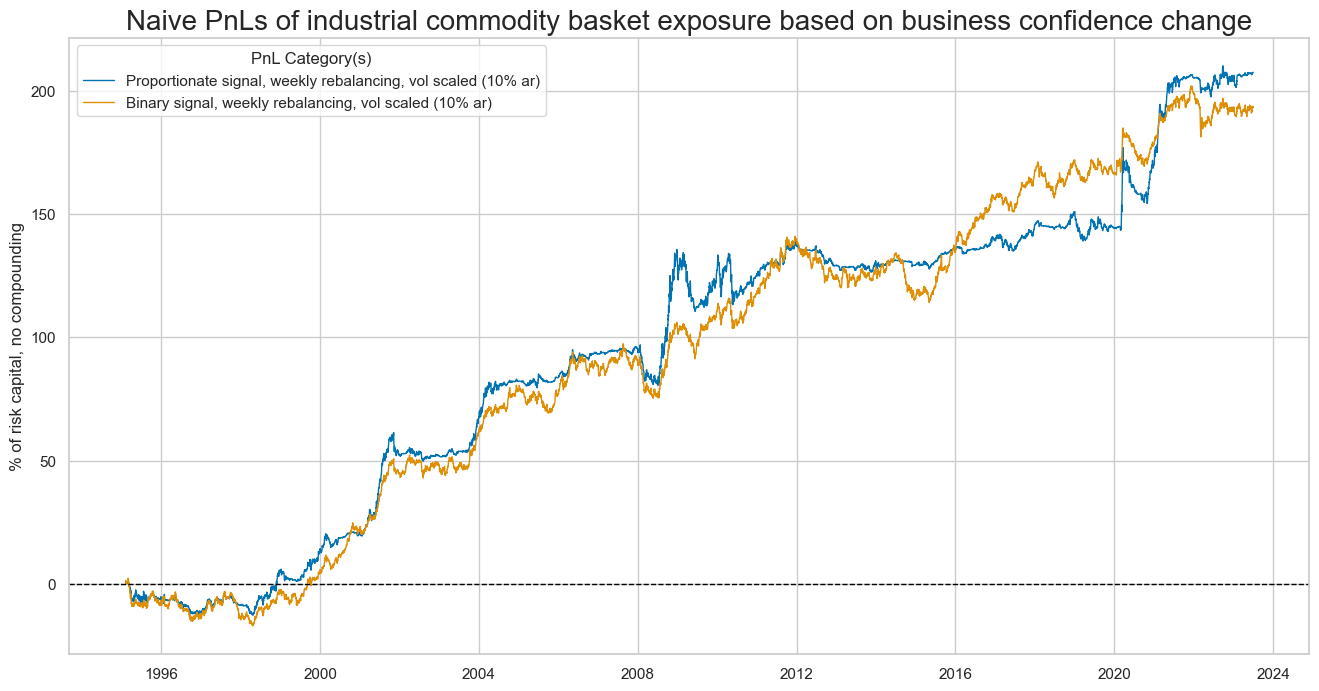

In [23]:
dix = dict_cogb

sigx = dix["sig"]
naive_pnl = dix["pnls"]
pnls = [sigx + x for x in ["_PZN", "_BIN"]]  # + ["Long only"]

dict_labels = {"MBCSCORE_DZC_PZN":  "Proportionate signal, weekly rebalancing, vol scaled (10% ar)", 
               "MBCSCORE_DZC_BIN": "Binary signal, weekly rebalancing, vol scaled (10% ar)"
               }


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="1995-01-01",
    title="Naive PnLs of industrial commodity basket exposure based on business confidence change",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

Similar plot using different lookback periods: all lookback periods produce significant value

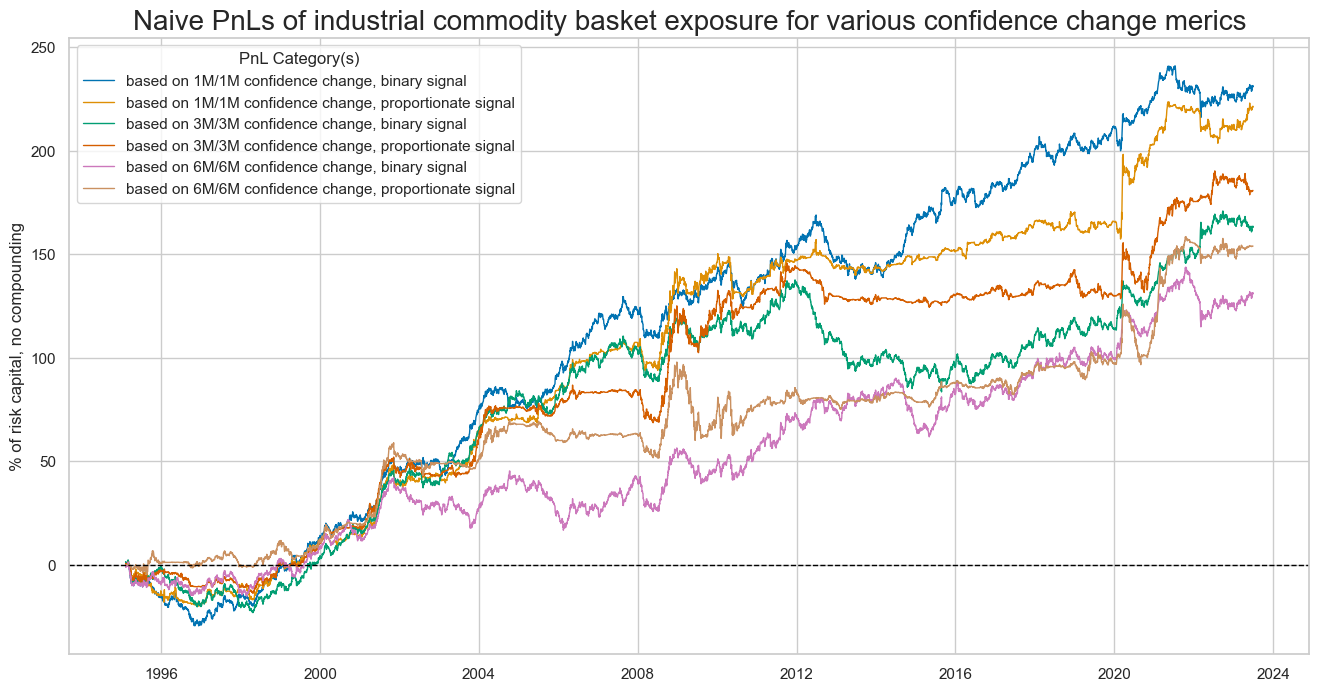

In [24]:
dix = dict_cogb

sigx = dix["rivs"]
naive_pnl = dix["pnls"]
pnls = sorted([sig + "_PZN" for sig in sigx] + [sig + "_BIN" for sig in sigx])

dict_labels = {"MBCSCORE_SA_D1M1ML1_ZN_BIN": "based on 1M/1M confidence change, binary signal", 
               "MBCSCORE_SA_D1M1ML1_ZN_PZN": "based on 1M/1M confidence change, proportionate signal",
               "MBCSCORE_SA_D3M3ML3_ZN_BIN": "based on 3M/3M confidence change, binary signal", 
               "MBCSCORE_SA_D3M3ML3_ZN_PZN": "based on 3M/3M confidence change, proportionate signal",
               "MBCSCORE_SA_D6M6ML6_ZN_BIN": "based on 6M/6M confidence change, binary signal", 
               "MBCSCORE_SA_D6M6ML6_ZN_PZN": "based on 6M/6M confidence change, proportionate signal"
               }

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="1995-01-01",
    title="Naive PnLs of industrial commodity basket exposure for various confidence change merics",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

and here is the summary of key performance metrics for composite signals (proportional and binary) as well as separately for different lookback periods

In [25]:
dix = dict_cogb

sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [sig + type for sig in sigx for type in ["_PZN", "_BIN"]] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)

In [26]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar) Sharpe Ratio  \
xcat                                                                        
Long only                          3.27072         10.293625     0.317742   
MBCSCORE_DZC_BIN                   7.97304         10.294277     0.774512   
MBCSCORE_DZC_PZN                  8.214574         10.446608     0.786339   
MBCSCORE_SA_D1M1ML1_ZN_BIN        9.224751         10.294186     0.896113   
MBCSCORE_SA_D1M1ML1_ZN_PZN        8.897724         10.386078     0.856697   
MBCSCORE_SA_D3M3ML3_ZN_BIN        6.751306         10.294995     0.655785   
MBCSCORE_SA_D3M3ML3_ZN_PZN        7.165727         10.524943     0.680833   
MBCSCORE_SA_D6M6ML6_ZN_BIN        5.178217         10.296179     0.502926   
MBCSCORE_SA_D6M6ML6_ZN_PZN        6.018743         10.581066     0.568822   

                           Sortino Ratio Max 21-day draw Max 6-month draw  \
xcat                                                                        
Long only                       0.439904      -20.244619       -30.526096   
MBCSCORE_DZC_BIN                1.126183      -14.433569        -18.74906   
MBCSCORE_DZC_PZN                 1.17003      -20.397715       -24.182846   
MBCSCORE_SA_D1M1ML1_ZN_BIN      1.317396      -14.439046       -22.263106   
MBCSCORE_SA_D1M1ML1_ZN_PZN      1.288769      -20.032111       -18.702389   
MBCSCORE_SA_D3M3ML3_ZN_BIN      0.951294      -12.152109       -24.805452   
MBCSCORE_SA_D3M3ML3_ZN_PZN      1.011832      -13.628268       -21.128816   
MBCSCORE_SA_D6M6ML6_ZN_BIN      0.722882       -14.42666       -25.209252   
MBCSCORE_SA_D6M6ML6_ZN_PZN      0.820413      -20.840759       -34.073601   

                           Traded Months  
xcat                                      
Long only                            282  
MBCSCORE_DZC_BIN                     282  
MBCSCORE_DZC_PZN                     282  
MBCSCORE_SA_D1M1ML1_ZN_BIN           282  
MBCSCORE_SA_D1M1ML1_ZN_PZN           282  
MBCSCORE_SA_D3M3ML3_ZN_BIN           282  
MBCSCORE_SA_D3M3ML3_ZN_PZN           282  
MBCSCORE_SA_D6M6ML6_ZN_BIN           282  
MBCSCORE_SA_D6M6ML6_ZN_PZN           282

## Pseudo panel analysis

### Specs and correlation test

Here we take a look at the predictive power of information states of global manufacturing confidence changes on individual industrial commodity contracts. The main signal is the global information state of the manufacturing confidence scores `MBCSCORE_DZC` and the target remains Vol-targeted commodity future return `COXR_VT10` 

In [27]:
sigs = [s for s in scorez if "MBC" in s] + ["MBCSCORE_DZC"]
ms = "MBCSCORE_DZC"
oths = list(set(sigs) - set([ms]))  # other signals
targ = "COXR_VT10"
cidx = cids_coms

dfxx = dfx.copy()

filt_cid = dfx["cid"] == "GLB"
filt_xcat = dfx["xcat"].isin(sigs)
dfco = dfx[filt_cid & filt_xcat]
for cid in cidx:
    dfcox = dfco.copy()
    dict_repl = {"GLB": cid}
    dfcox["cid"] = dfcox["cid"].replace(dict_repl)
    dfxx = pd.concat([dfxx, dfcox], axis=0, ignore_index=True)

dict_copp = {
    "df": dfxx,
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "black": None,
    "srr": None,
    "pnls": None,
}

In [28]:
dix = dict_copp

dfr = dix["df"]
sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]

srr = mss.SignalReturnRelations(
    dfr,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="1995-01-01",
)

dix["srr"] = srr

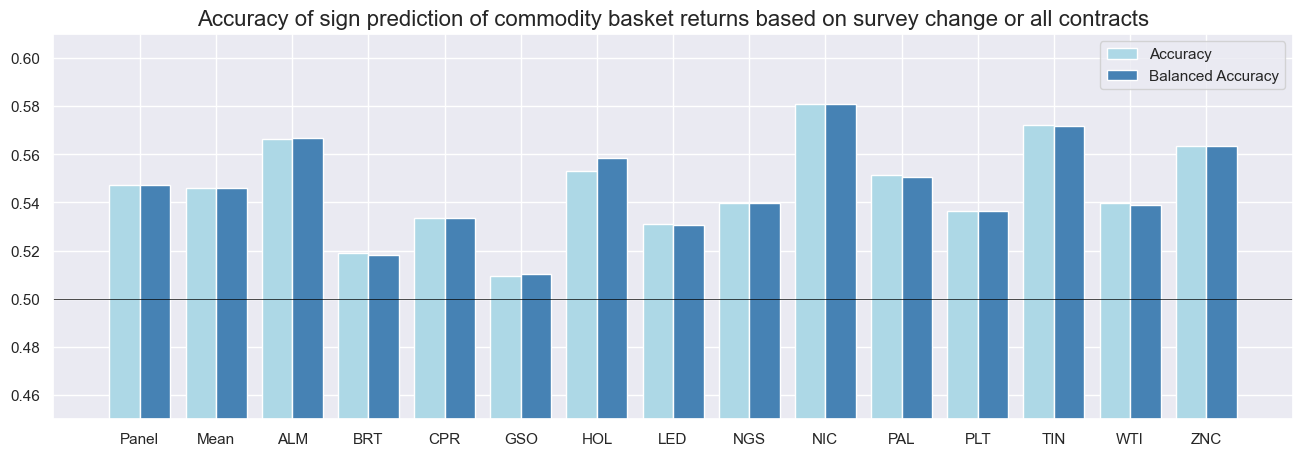

In [29]:
dix = dict_copp
srrx = dix["srr"]
srrx.accuracy_bars(
    type="cross_section",
    title="Accuracy of sign prediction of commodity basket returns based on survey change or all contracts",
    size=(16, 5),
)

Similarly positive correlation probability by contract, based on parametric and non-parametric tests has generally been high. For 9 out of 13 contracts it has been above 95% or 99%. Only lead posted a sub-50% positive correlation probability:

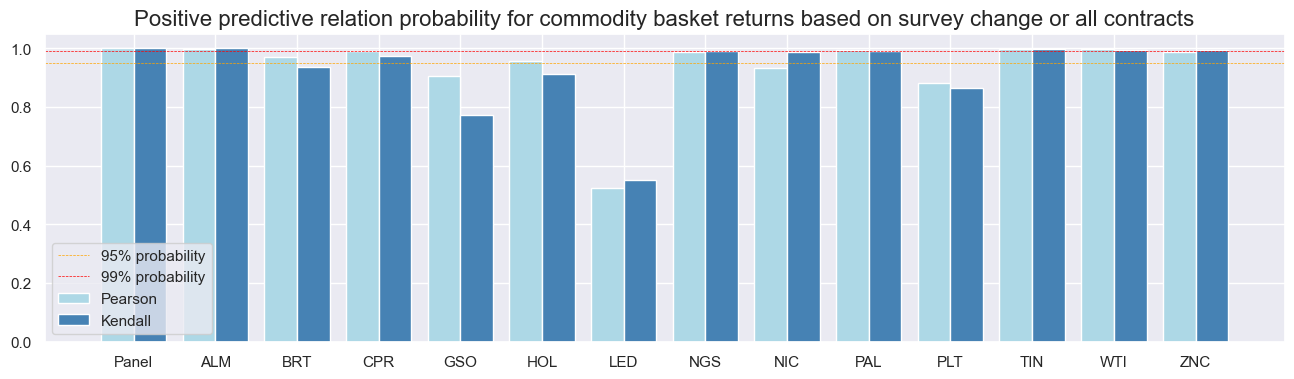

In [30]:
dix = dict_copp
srrx = dix["srr"]
srrx.correlation_bars(
    type="cross_section",
    title="Positive predictive relation probability for commodity basket returns based on survey change or all contracts",
    size=(16, 4),
)

### Naive PnL

We calculate stylized PnLs, i.e., dollar-based profit and loss developments over and above funding costs, according to standard rules that were applied in previous posts and for the strategies above. 

In [31]:
dix = dict_copp

dfr = dix["df"]
sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]


naive_pnl = msn.NaivePnL(
    dfr,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="1995-01-01",
    # bms=["USD_EQXR_NSA", "USD_GB10YXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=3,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="binary",
        thresh=3,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_BIN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

All commodities contributed to a survey-based futures contract PnL since 1995, notwithstanding the crude “one-size fits all” type of signal. There have been notable performance differences however, with Nickel recording the strongest PnL generation and U.S. gasoline the weakest.

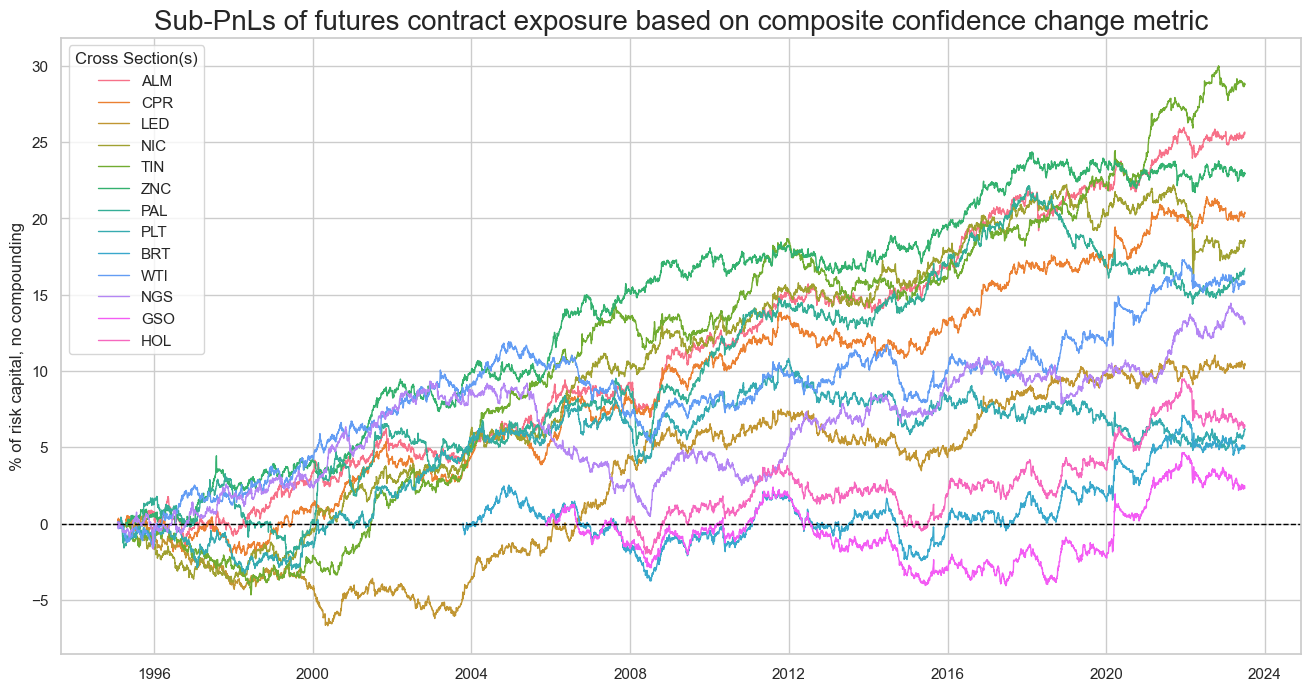

In [32]:
dix = dict_copp

sigx = dix["sig"]
cidx = dix["cidx"]
naive_pnl = dix["pnls"]
pnls = [sigx + "_BIN"]

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=cidx,
    start="1995-01-01",
    title="Sub-PnLs of futures contract exposure based on composite confidence change metric",
    xcat_labels=None,
    figsize=(16, 8),
)